### Imports

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton

In [52]:
def equivRate(rate, from_freq=1, to_freq=1):
  if from_freq == np.inf:
    return (np.exp(rate / to_freq) - 1) * to_freq
  elif to_freq == np.inf:
    return np.log(1 + rate / from_freq) * from_freq
  else:
    return to_freq * ((1 + rate/from_freq)**(from_freq/to_freq) - 1)

def coupon_bond_ymt(n, pmt, pv, fv=100, cf_freq=1, comp_freq=1, beg=False):
    def f(x):
        return coupon_bond_pv(n=n, pmt=pmt, rate=x, fv=fv, cf_freq=cf_freq, comp_freq=comp_freq, beg=beg) - pv
    root = newton(f, 0)
    return root

def coupon_bond_pv(n, pmt, rate, fv=100, cf_freq=1, comp_freq=1, beg=False):
    rate = equivRate(rate, from_freq=comp_freq, to_freq=cf_freq) / cf_freq
    old_settings = np.seterr(invalid='ignore')
    pvPMT = np.where(rate == 0, n, np.divide(1 - (1+rate)**-n, rate)) * pmt
    np.seterr(**old_settings)
    pvFV = fv / (1 + rate)**n
    return np.where(beg, (pvPMT + pvFV) * (1 + rate), pvPMT + pvFV)

def coupon_bond_fv(n, pmt, rate, terminal_payment, cf_freq=1, comp_freq=1, beg=False):
    rate = equivRate(rate, from_freq=comp_freq, to_freq=cf_freq) / cf_freq
    old_settings = np.seterr(invalid='ignore')
    fvPMT = np.where(rate == 0, n, np.divide((1+rate)**n - 1, rate)) * pmt
    np.seterr(**old_settings)        
    return np.where(beg, fvPMT * (1 + rate) + terminal_payment, fvPMT + terminal_payment)

def coupon_bond_pmt(n, rate, pv, fv, cf_freq=1, comp_freq=1):
    rate = equivRate(rate, from_freq=comp_freq, to_freq=cf_freq) / cf_freq
    pvaf = np.where(rate == 0, n, np.divide(1 - (1+rate)**-n, rate))
    return (pv - (fv/(1+rate)**n)) / pvaf

def zero_bond_ymt(n, pv, fv=100, freq=2):
    if freq == np.inf:
        return np.log(fv/pv) * (1/n)
    return ((fv/pv)**(1/(n*freq)) - 1) * freq

def zero_bond_pv(n, rate, fv=100, freq=2):
    if freq == np.inf:
        return fv / np.exp(rate*n)
    return fv / ((1 + rate/freq)**(n*freq))

def zero_bond_fv(n, rate, pv, freq):
    if freq == np.inf:
        return pv * np.exp(rate*n)    
    return pv * ((1 + rate/freq)**(n*freq))

def irr_newton(cf, cf_t, per=1):
    def price(rate, cf, cf_t, per=1):
        discount_factor = (1 + rate/per)**(-cf_t)
        return np.dot(cf, discount_factor)
    def f(x):
        return price(x, cf, cf_t, per=per)
    return newton(f, 0)

def irr_newton_no_scipy(stream, cf_t, per=1, tol=1e-12):
    rate = 0.0
    for steps in range(50): 
        r = np.array(cf_t)
        m = max(-rate * r / per)  
        f = np.exp(-rate * r / per - m)
        t = np.dot(f, stream)
        if abs(t) < tol * np.exp(-m):
            break
        u = np.dot(f * r, stream)
        rate = rate + np.clip(t / u, -1.0, 1.0)
    annualized_rate = (np.exp(rate / per) - 1) * per 
    return annualized_rate

### Yield Curves

Yield curves are a snapshot of interest rates in that market—a simple yet often informative graph that plots yields to maturity on the vertical axis and times to maturity on the horizontal axis for a homogeneous set of securities.

The idea of any yield curve in principle is to display visually the relationship between interest rates on securities that are alike on all dimensions except maturity. Ideally, all the observations would be for securities that have the same credit risk, same liquidity, same periodicity, and same tax status. 

Most yield curves are based on government securities. That’s so we can hold constant all the listed factors other than time to maturity that impact investors’ required rates of return. The yields to maturity ideally would be for zero‐coupon securities so that coupon reinvestment risk is not a factor.

There is no perfect data set for term structure analysis. Typically seen yield curves are plots of street convention yields on coupon-bearing Treasury notes and bonds instead of yields on Treasury STRIPS. In particular, the yields displayed usually are for on‐the‐run issues (i.e., the most recently auctioned Treasury securities). These are actively traded and typically are priced close to par value, thereby minimizing the effects of the deferral for tax purposes of the gains and losses from buying at a discount or a premium. The problem is that there are gaps in the times to maturity, so some yields have to be interpolated.

### Forward Curve Intuition

Suppose that yields to maturity on 1‐year, 2‐year, and 3‐year zero‐coupon government bonds are 1.00%, 2.00%, and 2.50%, respectively (quoted on semiannual basis). These rates are *0y1y*, *0y2y*, *0y3*, (*0y* securities trade in the "cash market"). The first number is the starting date or read as "years ahead" and the second number is the tenor of the bond.

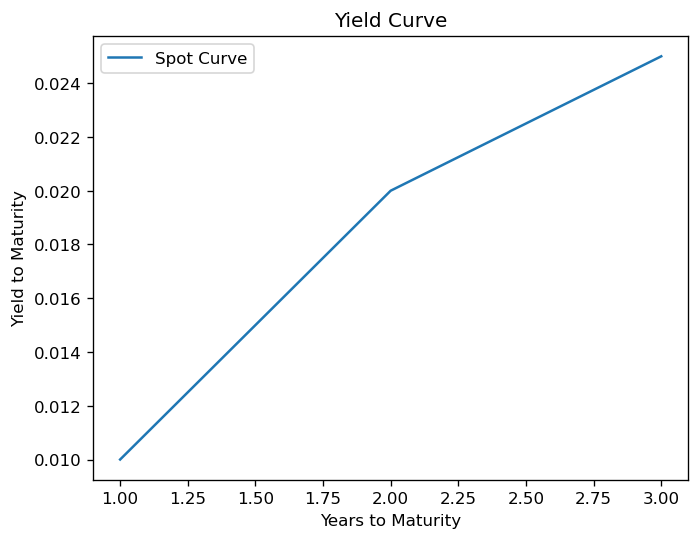

In [53]:
plt.figure(num=0, dpi=120)
plt.plot(np.array([1, 2, 3]), np.array([0.01, 0.02, 0.025]), label="Spot Curve")
plt.title('Yield Curve')
plt.xlabel('Years to Maturity')
plt.ylabel('Yield to Maturity')
plt.legend()

We can use the simple yield curve to infer the 1y1y, 1y2y, and 2y1y forward rates. These are implied yields on the 1-year bonds starting from one year and two years into the future (i.e. forward in time). 

At what rate must one be able to reinvest the proceeds of an investment in a shorter‐term bond to equal the proceeds of an investment in a longer‐term bond? The answer to this question is an Implied Forward Rate (IFR). 

Intuitively, the 1y1y IFR must be about 3.00% and the 2y1y IFR must be about 3.50% (ignore compounding for the this section). The idea is that if an investor can buy a 1‐year bond to yield 1.00% and reinvest for the second year at 3.00% (1y1y), the total return matches that of 2.00% per year on the 2‐year bond. Likewise, if an investor can buy the 2‐year at 2.00% and reinvest for the third year at 3.50% (2y1y), the same total return is obtained as on buying the 3‐year bond at 2.50%. Similarly, if a 1-year bond is purchased earning 1.00% for the first year and the proceeds are reinvested for the next two years at 3.25% per year (1y2y), the strategy produces the same return over the three years as buying the 3-year bond at an annual yield of 2.50%.

The simplified calculation (neglecting compounding) can be formalized as follows: let $Rate_{0yAy}$ be the shorter-term rate for the 0yAy time period, $Rate_{0yBy}$ for the longer-term rate for 0yBy period, and $Rate_{Ay(B-A)y}$ the implied forward rate starting from Ay for a tenor of B-Ay. 

$$Rate_{0yBy} \approx \left(\frac{AYears}{BYears}\times Rate_{0yAy}\right) + \left(\frac{BYears - A Years}{BYears}\times Rate_{Ay(B-A)y}\right)$$
$$Rate_{Ay(B-A)y} \approx \frac{BYears \times Rate_{0yBy} - AYears \times Rate_{0yAy}}{BYears-AYears}$$


The *longer‐term rate is a weighted average of the shorter‐term rate and the implied forward rate*, whereby the *weights are the shares of the overall time frame*.

In [54]:
def approx_ifr(short_rate, short_period, long_rate, long_period):
  return (long_period * long_rate - short_period * short_rate) / (long_period - short_period)

ifr_1y1y = approx_ifr(0.01, 1, 0.02, 2)
print(f'{ifr_1y1y = :0.2%}')
ifr_1y2y = approx_ifr(0.01, 1, 0.025, 3)
print(f'{ifr_1y2y = :0.2%}')
ifr_2y1y = approx_ifr(0.02, 2, 0.025, 3)
print(f'{ifr_2y1y = :0.2%}')

ifr_1y1y = 3.00%
ifr_1y2y = 3.25%
ifr_2y1y = 3.50%


The analogy of the implied forward rate is the same as the marginal cost (MC) and average cost (AC) in macroeconomics. The marginal cost curve intersects the average cost curve at its lowest point because the increasing marginal cost curve pulls the average cost down until the marginal cost increases past the average cost and begins to pull up the average cost curve, thus intersecting at the lowest point on the average cost curve.

Similarly, the buyer of a 2-year bond at 2.00% obtains an incremental, or marginal, return of 3.00% for the second year after earning 1.00% for the first year. The buyer of the 3‐year at 2.50% gets a marginal return of 3.50% for the third year after earning 2.00% for the first two years (or a 1‐year rate of 1.00% followed by 3.00%). This leads naturally to using the implied forward rate in **maturity choice decisions**. The issue will be how **one’s own expectation for a future rate compares to that priced into the forward curve**.

Consider an investor who has a known, certain 2‐year horizon and can buy any of these three zero‐coupon government bonds. The obvious strategy is to buy the 2‐year zero at 2.00% and lock in the rate of return (barring default on the government bond and neglecting inflation). But our investor might consider “riding the yield curve” and buy the 3‐year at 2.50%. The hope is that the yield at the time of sale is “low” (and the sale price is “high”). How low? Lower than 3.50%, the 2y1y IFR. The companion fear is that the yield is above 3.50%. Our investor might also consider buying the 1‐year at 1.00% and hope that rates rise for the second year. How high? Higher than 3.00%, the 1y1y implied forward rate. The risk is that the reinvestment rate is less than 3.00%. The forward curve is the benchmark for your hopes and fears.

The key point is that the investor’s maturity choice decision depends, in part at least, on the held view on future cash market rates vis‐à‐vis the implied forward rates. Other factors undoubtedly matter as well—the risk of underperforming the obvious maturity‐matching strategy, the cost of reinvesting cash, the cost and risk of having to sell the bond at the horizon date. In any case, implied forward rates provide information useful in making the decision.

### Theories of The Term Structure of Interest Rates

1. **Expectations Theory**: This theory posits that the shape of the yield curve reflects market participants' expectations about future short-term interest rates because investors (maximize expected rate of return) and issuers (minimize cost of borrowed funds) want to maximize outcomes. An upward-sloping yield curve suggests rising future rates, a downward-sloping curve indicates falling rates, while a flat curve indicates steady interest rates. The key assumption is that investors are *risk-neutral*, and the implied forward rate represents an unbiased forecast of future spot rates.
   1. **Key Assumption**: Investors are risk-neutral, meaning they do not demand additional compensation for holding long-term bonds over short-term ones. They are indifferent to the risk of future interest rate changes (the standard deviation), so they base their decisions entirely on expected returns (mean return).
   2. **Implication**: The yield curve reflects market expectations about future short-term interest rates. An upward-sloping yield curve means that short-term rates are expected to rise in the future, while a downward-sloping curve means they are expected to fall.
   3. **Forward Rates**: The forward rate (the rate implied by current long-term rates) is considered an unbiased predictor of future short-term rates. There is no risk premium.
2. **Segmented Markets Theory**: This theory suggests that the bond market is divided into segments based on maturities, and investors and issuers operate only within their preferred segment. As a result, the yield curve is determined by supply and demand conditions in each maturity segment independently, with no connection between short- and long-term rates. Risk aversion prevents investors from shifting between segments, so forward rates do not predict future short-term rates.
   1. **Key Assumption**: Investors and borrowers have strong preferences for certain maturities and typically do not switch between short-term and long-term bonds. Each maturity segment (short-term, medium-term, long-term) operates independently based on its own supply and demand.
   2. **Implication**: The yield curve is shaped by the independent supply and demand conditions in each segment, rather than expectations about future interest rates. For example, if there is more demand for short-term bonds, their yields may be lower than long-term bonds, even if future short-term rates are expected to remain unchanged.
   3. **No Relationship Between Segments**: Since investors don’t move between segments, short-term and long-term rates are determined separately. The forward rate does not predict future short-term rates.
3. **Liquidity Preference Theory**: This theory builds on the Expectations Theory by recognizing that investors are risk-averse and prefer short-term bonds due to their lower risk. To compensate for the increased risk of holding longer-term bonds (which are more sensitive to interest rate changes), investors demand a "liquidity premium." This results in an upward-sloping yield curve even when future short-term rates are expected to remain steady. The forward rate, therefore, tends to overestimate the expected future short-term rate due to this risk premium.
   1. **Key Assumption**: Investors are risk-averse and prefer short-term bonds because they are less risky (less sensitive to interest rate fluctuations). To hold long-term bonds, investors demand a liquidity premium as compensation for the higher risk.
   2. **Implication**: Even if investors expect future short-term rates to remain steady, the yield curve is typically upward-sloping because of the liquidity premium attached to long-term bonds. Longer-term bonds require higher yields to attract investors due to their greater risk.
   3. **Forward Rates Overestimate**: The forward rate reflects both expected future short-term rates and the liquidity premium. This means the forward rate tends to overestimate future short-term rates since it includes compensation for risk. If it were somehow possible to extract each risk premium, we would have the "core yield" curve based only on expectations. However, with liquidity premiums built into the implied forward rates, forward rates are overestimates of the future rates.

**In Summary**:
1. **Expectations Theory**: The yield curve reflects pure expectations of future short-term rates, with no premium for risk.
2. **Segmented Markets Theory**: The yield curve is shaped by separate supply and demand dynamics in each maturity segment, independent of expectations about future rates.
3. **Liquidity Preference Theory**: The yield curve reflects both expectations of future short-term rates and a premium for holding longer-term, riskier bonds.

### Implied Forward Curve

An accurate formula for implied forwards that includes compounding for specific periodicity (PER) for the yields is based on the expression shown below:

$$i_{t_{1},t_{2}}=\left[\frac{(1+i_{t_{0},t_{2}})^{t_{2}-t_{0}}}{(1+i_{t_{0},t_{1}})^{t_{1}-t_{0}}}\right]^{\frac{1}{(t_{2}-t_{1})}}-1$$

$$(1+i_{t_{0},t_{2}})^{t_{2}-t_{0}}=(1+i_{t_{0},t_{1}})^{t_{1}-t_{0}} (1+i_{t_{1},t_{2}})^{t_{2}-t_{1}}$$

$$\left(1+\frac{Rate_{t_{0},t_{1}}}{Per}\right)^{(t_{1}-t_{0})} \times \left(1+\frac{Rate_{t_{1},t_{2}}}{Per}\right)^{(t_{2}-t_{1})}  = \left(1+\frac{Rate_{t_{0},t_{2}}}{Per}\right)^{(t_{2}-t_{0})} $$

$$Rate_{t_{1},t_{2}} = \left(\left[\frac{\left(1+\frac{Rate_{t_{0},t_{2}}}{Per}\right)^{(t_{2}-t_{0})}}{\left(1+\frac{Rate_{t_{0},t_{1}}}{Per}\right)^{(t_{1}-t_{0})}}\right]^{\frac{1}{(t_{2}-t_{1})}} - 1 \right) \times Per$$

$t_{A},t_{B}$ or *AyBy* or *AmBy* mean: A years ahead (forward time period/starting period), B tenor of the underlying security

The first term is the proceeds per unit invested for $t_{1}$ years assuming that the $t_{0},t_{1}$ rate is an APR quoted for PER periods per year. That amount is reinvested for the remaining time period out to year $t_{2} - t_{1}$ (i.e., at the $t_{1},t_{2}$ implied forward rate). The compounded total return equals the proceeds per unit invested for $t_{2}$ years at the $t_{0},t_{2}$ rate. It is important that all three rates are annualized for the same periodicity.

[FRED Reference](https://fredblog.stlouisfed.org/2023/05/constructing-forward-interest-rates-in-fred/)

Note that the formulas are appropriate for bond yields and not money market rates as these require some modifications.

In [55]:
def ifr(rate_t0t1, t1, rate_t0t2, t2, t0 = 0, per=2):
    t2_term = (1 + rate_t0t2/per)**(t2 - t0)
    t1_term = (1 + rate_t0t1/per)**(t1 - t0) 
    return ((t2_term / t1_term)**(1/(t2 - t1)) - 1) * per

ifr_1y1y = ifr(0.01, 1, 0.02, 2)
print(f'{ifr_1y1y = :0.4%}')
ifr_1y2y = ifr(0.01, 1, 0.025, 3)
print(f'{ifr_1y2y = :0.4%}')
ifr_2y1y = ifr(0.02, 2, 0.025, 3)
print(f'{ifr_2y1y = :0.4%}')

ifr_1y1y = 3.0050%
ifr_1y2y = 3.2542%
ifr_2y1y = 3.5037%


### Money Market Implied Forward Rates

Money market instrument rates have different periodicities and the basis in which the forward rate is quoted should match the manner in which a similar security would be quoted and traded. Thus, the function to compute the implied forward rate for add-on rates and discount rates are as following:

IFR on an Add-On Basis (bank CDs, LIBOR, repos):
$$\left[1+\left(AOR_{t_{0},t_{1}}\frac{t_{1} Days}{Year}\right)\right] \times \left[1+\left(AOR_{t_{1},t_{2}}\frac{t_{2} - t_{1} Days}{Year}\right)\right]  = \left[1+\left(AOR_{t_{0},t_{2}}\frac{t_{2} Days}{Year}\right)\right] $$

$$AOR_{t_{1},t_{2}} = \left[\frac{t_{2} Days \times AOR_{t_{0},t_{2}} - t_{1} Days \times AOR_{t_{0},t_{1}}}{t_{2} - t_{1} Days}\right] \times \left[\frac{1}{1 + \left(AOR_{t_{0},t_{1}}\times \frac{t_{1} Days}{Year}\right)}\right]$$

IFR on a Discount Rate Basis (commercial paper, bankers acceptances, and Treasury bills in the U.S):
$$\left[1-\left(DR_{t_{0},t_{1}}\frac{t_{1} Days}{Year}\right)\right] \times \left[1-\left(DR_{t_{1},t_{2}}\frac{t_{2} - t_{1} Days}{Year}\right)\right]  = \left[1-\left(DR_{t_{0},t_{2}}\frac{t_{2} Days}{Year}\right)\right] $$

$$DR_{t_{1},t_{2}} = \left[\frac{t_{2} Days \times DR_{t_{0},t_{2}} - t_{1} Days \times DR_{t_{0},t_{1}}}{t_{2} - t_{1} Days}\right] \times \left[\frac{1}{1 - \left(DR_{t_{0},t_{1}}\times \frac{t_{1} Days}{Year}\right)}\right]$$


Suppose that 90‐day LIBOR is 1.00% (periodicity of 4) and 180‐day LIBOR is 2.00% (periodicity of 2). What rate would a true believer in the expectations theory of the yield curve anticipate for 90‐day LIBOR, 90 days into the future (*90d90d*)?

In [56]:
# Implied Forward Curve - MM Add-On & Discount Rate
def ifr_mm(aor_t0t1, t1, aor_t0t2, t2, t0 = 0, year=360, aor=True):
    rollover_avg = (t2 * aor_t0t2 - t1 * aor_t0t1) / (t2 - t1)
    adjust = 1/(1 + (aor_t0t1 * t1/year)) if aor else 1/(1 - (aor_t0t1 * t1/year))
    return rollover_avg * adjust


d90 = 90
r90 = 0.01
d180 = 180
r180 = 0.02
year = 360

# IFR - Add-On Rate
ifr_90d90d = ifr_mm(r90, d90, r180, d180, 0, 360, True)
print(f'{ifr_90d90d = : 0.4%}')

d180 = 180
r180 = 0.1
d360 = 360
r360 = 0.2
year = 360

ifr_180d180d = ifr_mm(r180, d180, r360, d360, 0, 360, True)
print(f'{ifr_180d180d = : 0.4%}')

ifr_90d90d =  2.9925%
ifr_180d180d =  28.5714%


In [57]:
d90 = 90
r90 = 0.01
d180 = 180
r180 = 0.02
year = 360

# IFR - Discount Rate
ifr_90d90d = ifr_mm(r90, d90, r180, d180, 0, 360, False)
print(f'{ifr_90d90d = : 0.4%}')

d180 = 180
r180 = 0.1
d360 = 360
r360 = 0.2
year = 360

ifr_180d180d = ifr_mm(r180, d180, r360, d360, 0, 360, False)
print(f'{ifr_180d180d = : 0.4%}')

ifr_90d90d =  3.0075%
ifr_180d180d =  31.5789%


### Implied Spot (Zero-Coupon) Rates

Implied spot curve is the sequence of spot (or zero‐coupon) rates that are consistent with the prices and yields on coupon bonds.

Building the implied spot curve is a great example of **“bootstrapping”** in that the result of one calculation is used in the subsequent one. This is not going to involve a specific formula; instead it is a process best learned by working through an example.

Suppose that we observe price and yield data on four actively traded benchmark securities for the same risk class, for instance, government bonds.

| Maturity (Years) | Coupon Rate | Price (% of Par Value) | Yield to Maturity |
| ---------------- | ----------- | ---------------------- | ----------------- |
| 1                | 0%          | 97.0625                | 3.0264%           |
| 2                | 3.25%       | 100.8750               | 2.7941%           |
| 3                | 4.50%       | 102.7500               | 3.5181%           |
| 4                | 4.00%       | 99.3125                | 4.1902%           |

We need some simplifying *assumptions* to illustrate bootstrapping:
- We require a starting place in the money market where we observe the pricing on a short‐term zero‐coupon bond. Here the 1‐year represents the **starter zero**. But keep in mind that in practice we would use the price on a **T‐bill or commercial paper or a time deposit that pays LIBOR** which is obtained from the money market.
- The 2‐year, 3‐year, and 4‐year bonds are assumed make **annual coupon payments** to simplify the example. 
- Assume that **we are on a coupon date and the payment has just been made** so that there is **no accrued interest**.
  - In general, you would need to use the total current market value including accrued interest on the left side of the equation.
- The internal rates of return are street convention yields for a periodicity of 1 (i.e., they are **effective annual rates**).

In [69]:
years = np.array([1, 2, 3, 4])
coupon = np.array([0, 3.25, 4.5, 4])
price = np.array([97.0625, 100.875, 102.75, 99.3125])
face = np.full(4, 100)
ytm = np.vectorize(coupon_bond_ymt)(n=years, pmt=coupon, pv=price, fv=face, cf_freq=1, comp_freq=1, beg=False)
print(ytm)

[0.03026401 0.0279408  0.03518092 0.04190249]


We know the 0y1y zero-coupon/spot rate is 3.0264%. Using this we will bootstrap the spot rates for rest of the maturities. 

**0y2y**: The implied 2‐year spot rate (the 0y2y) is 2.7903%; it is the solution for *z* in the below expression. The algebra problem is to find the 2‐year spot rate such that when the second cash flow is discounted by that rate, the sum is the price of the bond.

$$100.8750 = \frac{3.25}{1.030264} + \frac{103.25}{(1+\mathit{z})^{2}}, \mathit{z} = 0.027903$$

**0y3y**: The implied 3‐year spot rate 0y3y is 3.5476%. Our 0y2y result is now an input into the equation and is used to discount the second cash flow. This is what is meant by bootstrapping the curve.

$$102.7500 = \frac{4.50}{1.030264} +  \frac{4.50}{(1.027903)^{2}} +  \frac{104.50}{(1+\mathit{z})^{3}}, \mathit{z} = 0.035476$$

**0y4y**: The implied 4-year spot rate (the 0y4y) is 4.2525%. The formula uses the inital 0y1y starter zero and the 0y2y and 0y3y implied rates. 

$$99.3125 = \frac{4}{1.030264} +  \frac{4}{(1.027903)^{2}} + \frac{4}{(1.035476)^{3}} +  \frac{104}{(1+\mathit{z})^{3}}, \mathit{z} = 0.042525$$

In [59]:
def spot_rate(years, coupon, spots, price, face):
    pvPMT = np.sum(np.full(years-1, coupon) * ((1 + spots)**-np.arange(1,years)))
    return ((face + coupon) / (price - pvPMT))**(1/years) - 1

spots = [ytm[0]]
for i in range(1,len(ytm)):
    spots.append(spot_rate(years[i], coupon[i], np.array(spots), price[i], face[i]))

spots = np.array(spots)
print(spots)

[0.03026401 0.0279033  0.03547566 0.04252524]


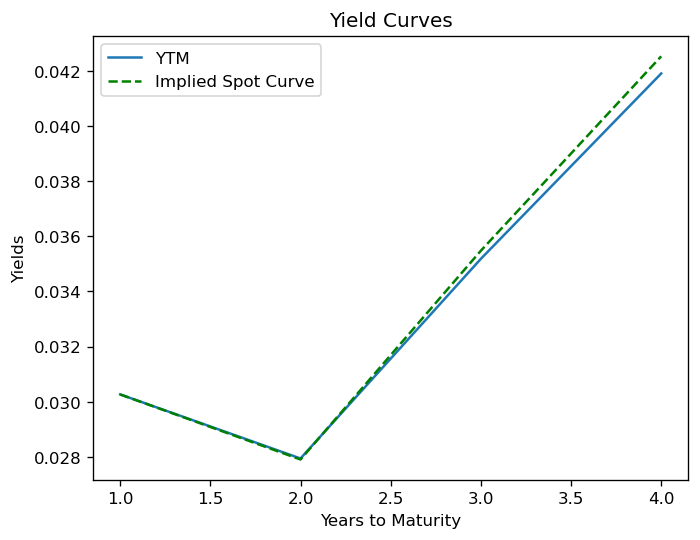

In [60]:
import matplotlib.pyplot as plt

plt.figure(num=0, dpi=120)
plt.plot(years, ytm, label="YTM")
plt.plot(years, spots, "--g", label="Implied Spot Curve")
plt.title('Yield Curves')
plt.xlabel('Years to Maturity')
plt.ylabel('Yields')
plt.legend()

These equations demonstrate why a yield‐to‐maturity statistic can be interpreted as a “present value average” of the zero‐coupon rates. Consider the 4‐year bond in this example. Its price is the sum of the discounted cash fl ows using either the yield to maturity or the sequence of spot rates.

$$\frac{4}{1.030264} +  \frac{4}{(1.027903)^{2}} + \frac{4}{(1.035476)^{3}} +  \frac{104}{(1.042525)^{3}} = 99.3125$$

$$\frac{4}{1.041902} +  \frac{4}{(1.041902)^{2}} + \frac{4}{(1.041902)^{3}} +  \frac{104}{(1.041902)^{3}} = 99.3125$$

Here 4.1902% is a “weighted average” of 3.0264%, 2.7903%, 3.5476%, and 4.2525%, with most of the weight on the last spot rate because it corresponds to the largest cash flow.

### Par Curve

The implied spot curve can be used to derive a related description of the market, assuming no arbitrage. This is the **par curve**—the sequence of yields such that the bond for each time to maturity trades at par value.

Consider for example for earlier:

| Maturity (Years) | Coupon Rate | Price (% of Par Value) | Yield to Maturity |
| ---------------- | ----------- | ---------------------- | ----------------- |
| 1                | 0%          | 97.0625                | 3.0264%           |
| 2                | 3.25%       | 100.8750               | 2.7941%           |
| 3                | 4.50%       | 102.7500               | 3.5181%           |
| 4                | 4.00%       | 99.3125                | 4.1902%           |

We have bootstrapped the Spot Rates:
| Maturity (Years) | Coupon Rate | Price (% of Par Value) | Yield to Maturity | Spot Rates |
| ---------------- | ----------- | ---------------------- | ----------------- |------------|
| 1                | 0%          | 97.0625                | 3.0264%           | 3.0264%    |
| 2                | 3.25%       | 100.8750               | 2.7941%           | 2.7903%    |
| 3                | 4.50%       | 102.7500               | 3.5181%           | 3.5476%    |
| 4                | 4.00%       | 99.3125                | 4.1902%           | 4.2525%    |

Par Rate for 0y4y:

$$100 = \frac{PMT}{1.030264} + \frac{PMT}{(1.027903)^{2}} + \frac{PMT}{(1.035476)^{3}} + \frac{PMT + 100}{(1.042525)^{4}}, PMT = 4.1876$$

Each cash flow is discounted using the corresponding implied spot rate. So, while the actual 4%, 4‐year bond is trading at a small discount to yield 4.1902%, we now deduce that a hypothetical 4.1876%, 4‐year bond would be priced at par value.

To convert **spot rates** (or zero-coupon yields) into **par rates** we use a process that involves discounting future payments. To formalize the conversion from **zero-coupon yields** to **par rates**, let's break it down mathematically.

1. **Spot Rate (Zero-Coupon Yield):**
The spot rate $z_t$ (or zero-coupon yield) for year $t$ represents the yield of a zero-coupon bond maturing in $t$ years. The price $ P_t$ of this zero-coupon bond is calculated as:

$$P_t = \frac{1}{(1 + z_t / f)^t}$$
Where:
- $z_t$ is the spot rate for year $t$,
- $f$ is the frequency of coupon payments (typically $f = 1$ for annual payments),
- $t$ is the year or time to maturity.

2. **Annuity Calculation:**
The **annuity** in the code is the present value of receiving a series of coupon payments over time, discounted at the spot rates. Mathematically, for a bond with a coupon $C$ paid over $T$ periods, the annuity $A_T$ at year $T$ is:

$$A_T = \sum_{t=1}^{T} \frac{C}{(1 + z_t / f)^t}$$

In this case, since the coupon rate is normalized (the par rate itself is calculated), the annuity becomes the sum of the discounted values of the coupon payments.

3. **Present Value of Redemption:**
The **present value of the redemption** refers to the discounted value of the bond's face value at maturity (which is usually 100):

$$PV_{\text{redeem}} = \frac{1}{(1 + z_T / f)^T}$$

Where $T$ is the maturity period. This term represents the value of receiving the face value at maturity, discounted by the spot rate for that period.

4. **Present Value of Coupons (PV of Coupons):**
The **PV of coupons** is the complement to the redemption value:

$$PV_{\text{cpns}} = 1 - PV_{\text{redeem}}$$

This represents the proportion of the total value attributed to the coupon payments, after accounting for the face value repayment.

5. **Par Rate Calculation:**
The **par rate** is the coupon rate that makes the bond's price equal to its face value (typically 100) when discounted at the spot rates. It can be expressed as:

$$\text{Par Rate}_T = \frac{PV_{\text{cpns}}}{A_T} \times f$$

Where:
- $PV_{\text{cpns}}$ is the present value of coupons (the complement to redemption),
- $A_T$ is the annuity (present value of coupon payments over time),
- $f$ is the payment frequency (e.g., 1 for annual payments).

In the code, this par rate is computed iteratively by summing the present value of coupons (through the annuity) and adjusting for the present value of the face value redemption.

**Formalization of the Conversion Function**:
Now, we can formalize the steps of the function **zero_to_par**:

1. **Zero-Coupon Bond Price:** Calculate the price of zero-coupon bonds based on the given spot rates:
   $$P_t = \frac{1}{(1 + z_t / f)^t}, \quad t = 1, 2, \ldots, T$$

2. **Annuity (Sum of Coupon Payments):** Compute the present value of coupon payments (annuity):
   $$A_T = \sum_{t=1}^{T} P_t$$

3. **Present Value of Redemption:** Calculate the present value of redeeming the bond at maturity:
   $$PV_{\text{redeem}} = P_T$$

4. **Present Value of Coupons:** The present value of the coupons is:
   $$PV_{\text{cpns}} = 1 - PV_{\text{redeem}}$$

5. **Par Rate Calculation:**
   $$\text{Par Rate}_T = \frac{PV_{\text{cpns}}}{A_T} \times f$$

---

In summary:
- The function computes the **par rate** by balancing the discounted present value of coupon payments against the present value of redeeming the bond at face value.
- The **par rate** is the coupon rate that equates the bond's price to its face value, taking into account the zero-coupon yields (spot rates).

In [61]:
import numpy as np

# Convert spot rates (zero yields) to par rates
def zero_to_par(zero_yields, freq=1):
    # Time periods (1, 2, 3, ..., n)
    t = np.arange(len(zero_yields)) + 1
    
    # Zero-coupon bond prices based on spot rates
    zero_prices = (1 + zero_yields / freq) ** (-t)
    
    # Initialize variables
    annuity = 0
    par = np.empty_like(zero_prices)
    
    # Calculate par rates iteratively
    for i, zero_price in enumerate(zero_prices):
        annuity += zero_price  # Update annuity (sum of discounted coupon payments)
        pv_redeem = zero_price  # Present value of redeeming the bond
        pv_cpns = 1 - pv_redeem  # Present value of coupons (complement to redemption)
        
        # Par rate calculation
        par[i] = (pv_cpns / annuity) * freq
        
    return par

# Run the function to convert spot rates to par rates
par_rates = zero_to_par(spots)
print(par_rates)


[0.03026401 0.02793574 0.03524051 0.0418762 ]


In [62]:
from bond_pricing import par_yld_to_zero

par_yld_to_zero(par_rates, freq=1, return_dataframe=True)

,zero_yields,zero_prices,forward_rates
0,0.030264,0.970625,0.030264
1,0.027903,0.946445,0.025548
2,0.035476,0.900700,0.050788
3,0.042525,0.846552,0.063963


### Forward Curve

An obvious application for bootstrapping the implied spot curve is to get the zero‐coupon rates needed to derive the implied forward curve. That is, the implied spot curve can be just an intermediate step to get to get the information we need to help make a maturity
choice decision.

In [63]:
forwards = [spots[0]]
for i in range(len(spots)-1):
    forwards.append(ifr(rate_t0t1=spots[i], t1=(i+1), rate_t0t2=spots[i+1], t2=(i+2), per=1))

forwards = np.array(forwards)
print(forwards)

[0.03026401 0.025548   0.05078814 0.06396326]


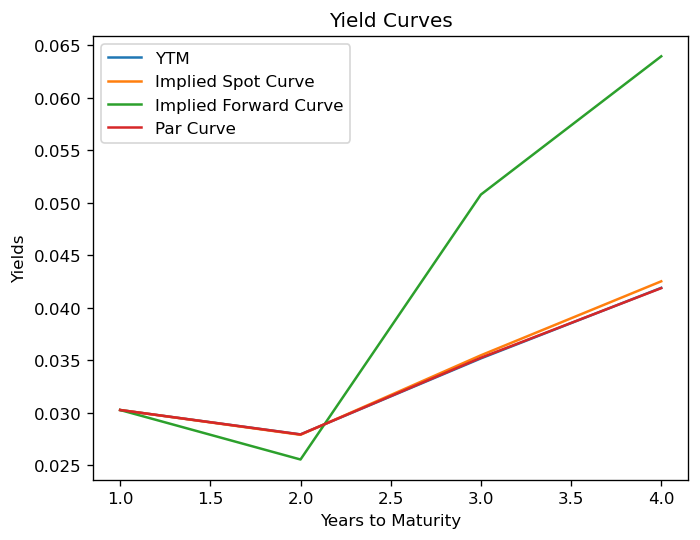

In [64]:
import matplotlib.pyplot as plt

plt.figure(num=0, dpi=120)
plt.plot(years, ytm, label="YTM")
plt.plot(years, spots, label="Implied Spot Curve")
plt.plot(years, forwards, label="Implied Forward Curve")
plt.plot(years, par_rates, label="Par Curve")
plt.title('Yield Curves')
plt.xlabel('Years to Maturity')
plt.ylabel('Yields')
plt.legend()

### Credit Spread Over Benchmark Bonds - *Z-Spread*

Another clever application of the implied spot curve is in calculating the credit spread over benchmark bonds. Suppose we are analyzing a 4‐year, level‐payment, fully amortizing bank loan. The bank loan is priced at par value and makes an annual payment of 28.2 (percent of par value), including both principal and interest. Its yield to maturity is 4.9982%.

$$100 = \frac{28.2}{1+\mathit{y}} + \frac{28.2}{(1+\mathit{y})^{2}} + \frac{28.2}{(1+\mathit{y})^{3}} + \frac{28.2}{(1+\mathit{y})^{4}}, y = 0.049982$$

In [73]:
# 4-year loan priced at par (pv = 100) 
loan_yield = coupon_bond_ymt(n=4,pmt=28.2, pv=100, fv=0, cf_freq=1, comp_freq=1)
print(f'{loan_yield = :0.3%}')

# 4-year par yield - Treasuries
print(f'4-year par yield = {par_rates[3]:0.3%}')

# Approx - Credit Spread
credit_spread = (loan_yield - par_rates[3]) * 10_000 # Using Par Yield
print(f'{credit_spread = :0.2f}bps')
credit_spread = (loan_yield - ytm[3]) * 10_000 # Using Actual 4-Year Bond Yield
print(f'{credit_spread = :0.2f}bps')

loan_yield = 4.998%
4-year par yield = 4.188%
credit_spread = 81.06bps
credit_spread = 80.79bps


The problem with these is that the “average life” of this amortizing bank loan is less than four years—the 4‐year Treasury yield is not the right benchmark.

A better way to assess the compensation for the credit risk (as well as any difference in liquidity and taxation) is to calculate the **static spread**, also known as the **zero‐volatility spread** or just **Z‐spread**. It is the uniform (hence, static) spread over the benchmark implied spot rates. It is the solution for the static spread, denoted *ss*, in this expression:

$$100 = \frac{28.2}{1.030264 + ss} + \frac{28.2}{(1.027903 + ss)^{2}} + \frac{28.2}{(1.035476 + ss)^{3}} + \frac{28.2}{(1.042525 + ss)^{4}}$$

In [66]:
def z_spread(spots, installment, n, price, face):
    def bond_price(rates, years, coupon, face=100):
        pvPMT = np.sum(np.full(years, coupon) * (1 + rates)**-np.arange(1, years+1))
        pvFV =  face / (1 + rates[-1])**years
        return pvPMT + pvFV
    
    def f(ss):
        rates = spots + ss
        return bond_price(rates=rates, years=n, coupon=installment, face=face) - price
    root = newton(f, 0.0, disp=False)
    return root

static_spread = z_spread(spots=spots, installment=28.2, n=4, price=100, face=0) * 10_000
print(f'{static_spread = :0.2f}bps')

static_spread = 140.48bps


### More Applications for the Implied Spot and Forward Curve

An obvious application for bootstrapping the implied spot curve is to get the zero‐coupon rates needed to derive the implied forward curve. That is, the implied spot curve can be just an intermediate step to get to get the information we need to help make a maturity
choice decision.

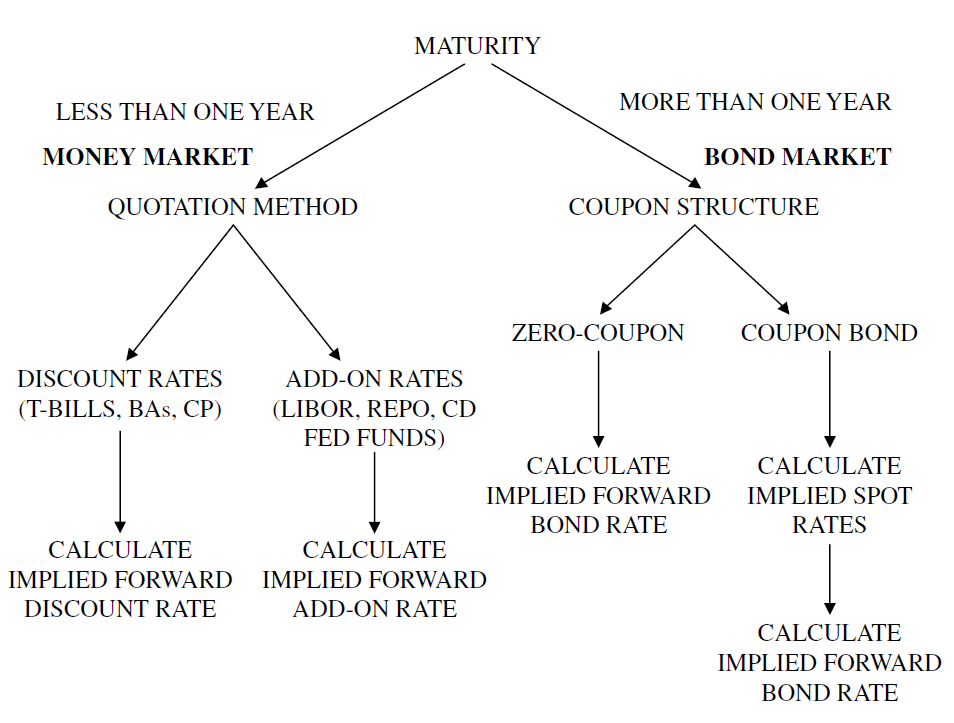

These examples and cases below demonstrate the interconnectedness between the underlying yield curve on traded coupon bonds, the implied spot, and implied forward rates. The connection is the **assumption of no arbitrage**.

#### Maturity-Choice Decision

Decision to invest over a long period to invest short-term and rollover:

| Maturity (Years) | Coupon Rate | Price (% of Par Value) | Yield to Maturity | Spot Rates |   IFR   |
| ---------------- | ----------- | ---------------------- | ----------------- |------------|---------|
| 1                | 0%          | 97.0625                | 3.0264%           | 3.0264%    | 3.0264% |
| 2                | 3.25%       | 100.8750               | 2.7941%           | 2.7903%    | 2.5548% |   
| 3                | 4.50%       | 102.7500               | 3.5181%           | 3.5476%    | 5.0788% |
| 4                | 4.00%       | 99.3125                | 4.1902%           | 4.2525%    | 6.3963% |


Suppose you have a 4‐year investment horizon and can buy any of the four government bonds in the preceding example. You are deciding whether to buy the 1‐year zero and reinvest at higher yields in each future year, you hope, or to buy the 4%, 4‐year bond. How high would rates have to be to prefer the rollover strategy? The answer, of course, is higher than the IFRs (computed after bootstrapping implied spot rates). To expect a higher total return after four years by buying and rolling over 1‐year bonds, you project the 1‐year yield to track a path, on average, above 2.55%, 5.08%, and 6.40%.

Decision to borrow in the money market on 6-month or 12-month LIBOR:

Now suppose that you are a commercial banker working with a middle market business customer on a 12‐month loan to build up working capital. The loan rate will be tied to 6‐month or 12‐month LIBOR. If the customer chooses 12‐month LIBOR (currently 4.00%), the cost of funds is set. But if the customer chooses 6‐month LIBOR (currently 3.50%), there is interest rate risk at the reset date in six months. Your customer asks for your recommendation. You know that the maturity‐choice decision depends on the rate view (i.e., where 6‐month LIBOR is expected to be vis‐à‐vis the implied forward rate). You also know that the 6m6m IFR is not 4.50% because of the periodicity problem. We can obtain the level for LIBOR of 4.42% (assuming 180 and 360 days).

The customer’s decision turns on whether 6‐month LIBOR is expected to be above or below 4.42% in six months. That might or might not be the rate that market participants in general are expecting. That does not matter—what matters is the decision maker’s own rate view. The commercial banker here can help the process by providing some historical data, the bank economist’s view on monetary policy and economic conditions, and the like. The advantage of the IFR is that as a breakeven rate it provides a framework for the above‐or‐below decision.

In [67]:
aor_t0t1 = 0.035
t1 = 180
aor_t0t2 = 0.04
t2 = 360
year = 360

libor_6m6m = ifr_mm(aor_t0t1=aor_t0t1, t1=t1, aor_t0t2=aor_t0t2, t2=t2, t0=0, year=year, aor=True)
print(f'{libor_6m6m = :0.4%}')

libor_6m6m = 4.4226%


#### Bond Valuation

The implied spot curve can be used in bond valuation. In the example, the 4‐year actively traded benchmark bond has a coupon rate of 4% and is priced at 99.3125 to yield 4.1902% on an annually compounded street convention basis.

| Maturity (Years) | Coupon Rate | Price (% of Par Value) | Yield to Maturity | Spot Rates |   IFR   |
| ---------------- | ----------- | ---------------------- | ----------------- |------------|---------|
| 1                | 0%          | 97.0625                | 3.0264%           | 3.0264%    | 3.0264% |
| 2                | 3.25%       | 100.8750               | 2.7941%           | 2.7903%    | 2.5548% |   
| 3                | 4.50%       | 102.7500               | 3.5181%           | 3.5476%    | 5.0788% |
| 4                | 4.00%       | 99.3125                | 4.1902%           | 4.2525%    | 6.3963% |

Suppose that we want to calculate the fair value on another 4‐year bond, this one having a 9% coupon rate. We neglect taxation and assume that this bond has the same liquidity and default risk as the four benchmark securities. The key point is that in a world of no arbitrage, this bond will not be priced to yield 4.1902%. Instead, its (no‐arbitrage) price is the present value of the cash flows discounted at the implied spot rates.

In [76]:
coupon = np.full(4, 9)
coupon[-1] += 100
discount_factor = ((1 + spots)**-(np.arange(4)+1))

price = np.dot(coupon, discount_factor)
print(f'{price = : 0.4f}')

ytm = coupon_bond_ymt(n=4, pmt=9, pv=price, fv=100, cf_freq=1, comp_freq=1)
print(f'{ytm = : 0.4%}')

price =  117.6341
ytm =  4.1274%


The usual candidates to explain why the yields on any two bonds differ are **time to maturity** (the *shape of the yield curve*), **credit risk** (the probability of default and the assumed recovery rate), **liquidity risk**, and **taxation**. This example reveals another reason—**coupon structure**. 

We have three 4‐year bonds for the same risk class: one yielding 4.2525% (the implied 0% coupon bond), another yielding 4.1902% (the benchmark 4% coupon bond), and this one yielding 4.1274% (the 9% coupon bond). The yield differences are entirely due to coupon structure. The more “weight” that is placed on the first few cash fl ows (i.e., the higher the coupon rate), the lower the yield to maturity. Of course, that conclusion depends on the shape of the curve.

#### Corporate Finance - Bonds of Corporate Issuers (same rating or same issuer) & DCF Analysis

Implied zero‐coupon rates can have applications in corporate finance as well. Let’s suppose now that the four **benchmark bonds are corporate securities for a specific bond rating**, say, single A. Better yet, we could assume that they are **unsecured liabilities of the same A‐rated issuer**. Even though there might be no market for zero‐coupon corporate bonds, we still can carry out the implied spot rate bootstrapping calculations. The idea is that if such corporate zeros did exist, they would have to trade at those spot yields if there were to be no arbitrage opportunities (and assuming no transactions costs to exploit those opportunities).

Suppose that we need to value some project that has credit risk deemed to be equivalent to the benchmark corporate bonds. Clearly, this is a valuation problem begging for discounted cash fl ow (DCF) analysis. Assume first that our analyst does the obvious—this is a 4‐year project, so he or she uses the 4‐year yield to maturity of 4.1902% to do the discounting. I have always wondered why DCF corporate finance problems, at least in the textbooks I’ve seen, invariably use a single discount rate or cost of capital for all time periods. Coming from a bond market perspective, I see the usually upward slope to the yield curve instructing us to discount year‐1 cash flow at a lower rate than year‐2 cash flow. 

Better analysis, in my opinion, is to use the implied spot rates (i.e., 3.0264%, 2.7903%, 3.5476%, and 4.2525%) instead of the yield on the maturity‐matching coupon bond. These implied spot rates correspond to the timing of the specific cash flows, which are no different than the face values on four zero‐coupon bonds. Depending on the amount and timing of the projected cash flows, this DCF calculation could produce a higher valuation for the project. All we have done to get the more appropriate discount rates is reconfigure data from the underlying yield curve and add the assumption of no arbitrage.

To be fair, the source of error in most corporate finance valuation problems is not the lack of precision in the discount rates in the denominators. Instead, the difficulty is uncertainty regarding the expected cash flows in the numerators. Often those numbers are just best‐guess projections of future sales and operating costs. Then our “laser‐sharp” implied spot rates represent bond math overkill. In those circumstances, we should use appropriate technology and discount all cash flows at some reasonable rate. However, there are situations when the numerators are scheduled amounts on scheduled dates—for instance, with financial contracts such as lease agreements or interest rate swaps. Then the implied spots could produce a better valuation.

#### Identify Arbitrage Opportunity

For hedge funds and proprietary trading desks at financial institutions, the implied spot curve is used to identify arbitrage opportunities. The two strategies discussed earlier are: (1) coupon stripping—buy the coupon bond and sell the cash flows separately as zero‐coupon coupon bonds (e.g., TIGRS, CATS, LIONS back in the early 1980s and Treasury STRIPS since 1985), and (2) bond reconstitution—buy the zero‐coupon bonds in sufficient quantity to build and sell a coupon bond. The implied spot curve identifies when one of these arbitrage strategies might be profitable.

By design, the implied spot curve is the sequence of zero‐coupon rates such that those trading two strategies break even. If actual zero‐coupon bonds are trading at yields above those implied rates, a bond reconstitution strategy might work. Actual zeros would have “high yields” and therefore “low prices” relative to breakeven. The arbitrageur buys the zeros, builds the coupon bond, and sells it for a profit. To be sure, the profit would have
to cover transactions costs. Those could be included directly, but then we would not have an implied spot curve; instead we would have an **implied spot cone**. An arbitrage opportunity arises when actual zeros are trading outside the cone. If actual zero‐coupon bonds can be sold at yields below the implied spot curve (or below the cone), the arbitrageur undertakes the coupon‐stripping strategy, as Merrill Lynch did in the 1980s when it created TIGRS.

#### Pricing Interest Rate Derivatives

A hugely important application for implied spot and forward rates is in pricing interest rate derivatives. We see this in interest rate swaps. The idea is that the forward curve is a sequence of “hedge‐able” future rates. They indicate the rates that can be locked in using derivatives. Once again the caveats are that there are no arbitrage opportunities and transactions costs are small enough to be neglected. Those are fine and acceptable assumptions in normal financial market conditions and active trading in derivatives.However, during a financial crisis when liquidity dries up, some arbitrage opportunities can lie there unexploited.

#### Horizon Yield on Coupon Bonds

A horizon yield on a coupon bond depends critically on coupon reinvestment rates. Remember that one of the assumptions in using the yield to maturity as a measure of an investor’s total return is that all coupons are reinvested at that same yield. Obviously, future rates are random. But suppose we can hedge that interest rate risk using costless and riskless
derivatives and can lock in rates along the implied forward curve. 

Consider again the 4‐year, 4% annual payment government bond priced at 99.3125 to yield 4.1902%. We calculated the IFRs above: The 1y1y is 2.5547%, the 2y1y is 5.0790%, and the 3y1y is 6.3961%. What will be the 4‐year horizon yield (i.e., the total pretax return after four years assuming no default) if coupons are in fact reinvested at those specific rates?

The total return turns out to be 117.314087 (percent of par value). the initial coupon is rolled over at the 1y1y, then the 2y1y and 3y1y IFRs. The second coupon is reinvested at the 2y1y and 3y1y, while the third is rolled over only once at the 3y1y IFR. The last coupon is received at maturity along with the principal.

Notice that 4.2525% is the 0y4y **implied spot rate**. Derivatives (in particular, costless and riskless derivatives) lock in for the investor the 4‐year spot rate, not the 4.1902% yield to maturity on the 4‐year bond.

In [136]:
n = 4
coupon = 4
face = 100
price = 99.3125

reinvestable_coupons = np.full(n-1, coupon)  
reinvestable_forwards = forwards[1:]

compound_factors = np.array([np.product(1 + reinvestable_forwards[i:]) for i in range(n-1)]) 

reinvestment_proceeds = np.sum(reinvestable_coupons * compound_factors)

# Holding Period Return (HPR)
total_return = reinvestment_proceeds + coupon + face
print("Total return at the end of holding period:", total_return)

ytm = (total_return/price)**(1/n) - 1
print(f'{ytm = :0.4%}')

Total return at the end of holding period: 117.31410346428962
ytm = 4.2525%


That is not a coincidence. Suppose that the bond buyer has only a 3‐year investment horizon. What is the 3‐year horizon yield assuming coupon reinvestment at the 1 × 2 and 2 × 3 IFRs and the ability to lock in using derivatives the sale price of the bond at the end of the third year at the 3 × 4 IFR? The total return after three years is 110.261642 (percent of par value).

In [137]:
n = 3
coupon = 4
face = 100
price = 99.3125

reinvestable_coupons = np.full(n-1, coupon)  
reinvestable_forwards = forwards[1:n]

compound_factors = np.array([np.product(1 + reinvestable_forwards[i:]) for i in range(n-1)]) 

reinvestment_proceeds = np.sum(reinvestable_coupons * compound_factors)

# Holding Period Return (HPR)
total_return = reinvestment_proceeds + coupon + ((coupon + face)/(1 + forwards[-1]))
print("Total return at the end of holding period:", total_return)

ytm = (total_return/price)**(1/n) - 1
print(f'{ytm = :0.4%}')

Total return at the end of holding period: 110.26142345401517
ytm = 3.5476%


### Discount Factors

Another way to calculate implied spot and forward rates is with discount factors. In fact, this is how yield curve analysis is carried out in practice using spreadsheets. **A discount factor is by definition the present value of one unit of currency at some future date.** A financial institution that has a multitude of loans, bonds, and derivative contracts to value needs discount factors that correspond to each future date for which cash is received or paid out. The key point is that spot rates and discount factors contain the same information. Discounting with spot rates is more intuitive, but using discount factors is easier implemented in code.


$$DF = \frac{1}{(1 + \mathit{z}_{n})^{n}}$$
$$\mathit{z}_{n} = DF^{-\frac{1}{n}}-1$$

$\mathit{z}_{n}$ is the spot rate (zero-coupon rate) at time *n*

We can calculate the implied forward rates (eg. for 1 year tenor) as ratios of consecutive discount factors for 1y1y, 2y1y, 3y1y, etc.

$$IRF_{t_{0},t_{1}} = \frac{DF_{0y,t_{0}y}}{DF_{0y,t_{1}y}}$$

$$IFR_{1y1y}=\frac{DF_{0y1y}}{DF_{0y2y}}$$
$$IFR_{2y1y}=\frac{DF_{0y2y}}{DF_{0y3y}}$$

We use the below annual payment securities to illustrate the discount factor bootstrapping process.

| Maturity (Years) | Coupon Rate | Price (% of Par Value) | Yield to Maturity |
| ---------------- | ----------- | ---------------------- | ----------------- |
| 1                | 0%          | 97.0625                | 3.0264%           |
| 2                | 3.25%       | 100.8750               | 2.7941%           |
| 3                | 4.50%       | 102.7500               | 3.5181%           |
| 4                | 4.00%       | 99.3125                | 4.1902%           |

The 1‐year bond has a coupon rate of zero and is priced at 97.0625 per 100 of par value. This one is easy: The price of zero‐coupon bond is its discount factor. So, the 1‐year discount factor, denoted $DF_{1}$ , is simply 0.970625. The 2‐year bond in the table has a coupon rate of 3.25% and is priced at 100.8750. The 2‐year discount factor is the solution for $DF_{2}$ in this equation.

$$100.8750 = (3.25 \times 0.970625) + (103.25 \times DF_{2}), DF_{2} = 0.946445$$

The bootstrapping process proceeds as in the section above where the implied spot rates are obtained. The difference is that now the algebra is much easier.

The 3‐year and 4‐year bonds have coupon rates of 4.50% and 4.00% and prices of 102.7500 and 99.3125, respectively. Working your way out the yield curve sequentially gets the next two annual discount factors. The output from the previous step becomes an input in the next step.

In [211]:
years = np.array([1, 2, 3, 4])
coupon = np.array([0, 3.25, 4.5, 4])
price = np.array([97.0625, 100.875, 102.75, 99.3125])
face = np.full(4, 100)

df = [price[0]/100]

for i in np.arange(len(coupon)-1) + 1:
    coupon_cf = np.full(i, coupon[i])
    pv_coupon = np.sum(coupon_cf * np.array(df))
    new_df = (price[i] - pv_coupon) / (coupon[i] + face[i])
    df.append(new_df)
    
df = np.array(df)
print("Discount Factors = ",df)

spots = df**-(1/years) - 1
print("Implied Spot Rates = ",spots)

forwards = df[:-1]/df[1:] - 1 # Implied forward rates as ratios of consecutive discount factors.
forwards = np.insert(forwards, 0, spots[0], axis=0)
print("Implied Forwards Rates = ", forwards)

Discount Factors =  [0.970625   0.94644522 0.90070033 0.84655209]
Implied Spot Rates =  [0.03026401 0.0279033  0.03547566 0.04252524]
Implied Forwards Rates =  [0.03026401 0.025548   0.05078814 0.06396326]


Once you have the discount factors, valuing fixed‐income bonds is straightforward. Remember the 9%, 4‐year bond in the previous section? Its price turned out to be 117.6342 when each payment is discounted using the implied spot rates. Now we just need to multiply the scheduled payments by the discount factors.

In [185]:
n = 4
cash_flows = np.full(4, 9)
cash_flows[-1] += 100
price = np.sum(cash_flows * df)
print(price)

117.63411318972062


Another application of the discount factors is to get the 4‐year **par yield**, which is the coupon rate on a bond that has a (flat) price equal to par value. It’s the solution for PMT in this equation.

$$DF = \frac{1}{(1 + z_t / f)^t}$$

$$PV = (DF_{1} \times PMT) + (DF_{2} \times PMT) + \cdots + (DF_{n} \times PMT) + (DF_{n} \times FV)$$ 

where, $DF_{n} \times FV = PV_{\text{Discount Bond Redemption}}$

and if FV = 1, $DF_{n} = PV_{\text{Discount Bond Redemption}}$

thus, $PV_{coupon} = 1 - PV_{redemption}$

$$1 - PV = (DF_{1} \times PMT) + (DF_{2} \times PMT) + \cdots + (DF_{n} \times PMT)$$ 

$$1 - PV = \sum_{n=1}^{N} DF \times PMT$$
$$PMT = \frac{1 - PV}{\sum_{n=1}^{N} DF}

In [208]:
year = 4
print(df)

par_coupon = (1 - (df[year-1]))/np.sum(df[:year]) * 100
print(f'{par_coupon = :0.7}')

[0.970625   0.94644522 0.90070033 0.84655209]
par_coupon = 4.18762
